# Tutorial 2: Entanglement Forging Solver for the $\mathrm{CH}_3$ molecule

In this tutorial, we apply Entanglement Forging to compute the ground state energy of a $\mathrm{CH}_3$ molecule. We use separate bitstrings lists for each subsystem, U and V.

### Import the relevant modules

In [1]:
from matplotlib import pyplot as plt
import numpy as np

from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.algorithms.optimizers import COBYLA
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import PySCFDriver
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.properties.second_quantization.electronic.bases import (
    ElectronicBasis,
)
from qiskit_nature.transformers.second_quantization.electronic.active_space_transformer import (
    ActiveSpaceTransformer,
)

from circuit_knitting_toolbox.entanglement_forging import (
    EntanglementForgingAnsatz,
    EntanglementForgingGroundStateSolver,
)
from circuit_knitting_toolbox.utils import IntegralDriver

### Define the $\mathrm{CH}_3$ molecule, define the active space transform, and instantiate an `ElectronicStructureProblem`

In [2]:
# Define a molecular system of interest - Methyl radical
molecule = Molecule(
    geometry=[
        ["C", [0.0, 0.0, 0.00]],
        ["H", [1.0790, 0.0, 0.00]],
        ["H", [-0.5395, -0.9344, 0.00]],
        ["H", [-0.5395, 0.9344, 0.00]],
    ],
    charge=0,
    multiplicity=2,
)

driver = PySCFDriver.from_molecule(molecule=molecule, basis="sto-3g")
converter = QubitConverter(JordanWignerMapper())

# Construct an active space composed of 6 molecular orbitals
transformer = ActiveSpaceTransformer(num_electrons=(3, 2), num_molecular_orbitals=6)
problem_reduced = ElectronicStructureProblem(driver, [transformer])

### Retrieve the one and two-body integrals and the nuclear repulsion energy. These will be used to decompose the operator into a bipartite system.

In [3]:
H_fermionic = problem_reduced.second_q_ops()[0]
electronic_energy_object = problem_reduced.grouped_property_transformed.get_property(
    "ElectronicEnergy"
)
nuclear_repulsion_energy = electronic_energy_object.nuclear_repulsion_energy

# These are the integrals in the molecular orbital basis retrieved from the 6 orbital active space.
one_body_integrals_alpha = electronic_energy_object.get_electronic_integral(
    ElectronicBasis.MO, 1
)._matrices[0]
one_body_integrals_beta = electronic_energy_object.get_electronic_integral(
    ElectronicBasis.MO, 1
)._matrices[1]

two_body_integrals_alpha_alpha = electronic_energy_object.get_electronic_integral(
    ElectronicBasis.MO, 2
)._matrices[0]
two_body_integrals_beta_alpha = electronic_energy_object.get_electronic_integral(
    ElectronicBasis.MO, 2
)._matrices[1]
two_body_integrals_beta_beta = electronic_energy_object.get_electronic_integral(
    ElectronicBasis.MO, 2
)._matrices[2]
two_body_integrals_alpha_beta = electronic_energy_object.get_electronic_integral(
    ElectronicBasis.MO, 2
)._matrices[3]

### Use the `IntegralDriver` and `ElectronicStructureProblem` objects to specify the entanglement-forged operator

In [4]:
# Create an ElectronicStructureProblem from our IntegralDriver and performing second quantization transformation
driver = IntegralDriver(
    hcore=one_body_integrals_alpha,
    mo_coeff=np.eye(6, 6),
    eri=two_body_integrals_alpha_alpha,
    num_alpha=3,
    num_beta=2,
    nuclear_repulsion_energy=nuclear_repulsion_energy,
)
problem = ElectronicStructureProblem(driver)

### Prepare the bitstrings and the ansatz. 

The ansatz for Entanglement Forging consists of a set of input bitstrings and a parameterized ansatz. If only one set of bitstrings is passed, it will be used for both subsystems. For this demo, we will specify different bitstrings for each subsystem.

In [5]:
bitstrings_u = [
    (1, 1, 1, 0, 0, 0),
    (0, 1, 1, 0, 0, 1),
    (1, 0, 1, 0, 1, 0),
    (1, 0, 1, 1, 0, 0),
    (0, 1, 1, 1, 0, 0),
]
bitstrings_v = [
    (1, 1, 0, 0, 0, 0),
    (0, 1, 0, 0, 0, 1),
    (1, 0, 0, 0, 1, 0),
    (1, 0, 0, 1, 0, 0),
    (0, 1, 0, 1, 0, 0),
]

# Define ansatz parameters:
brickwall = [
    (4, 5),
    (3, 4),
    (2, 3),
    (4, 5),
    (1, 2),
    (3, 4),
    (4, 5),
    (2, 3),
    (0, 1),
    (1, 2),
    (3, 4),
    (2, 3),
    (4, 5),
    (3, 4),
    (4, 5),
]

n_theta = len(brickwall)
nqubit = len(bitstrings_u[0])
theta = Parameter("θ")
hop_gate = QuantumCircuit(2, name="Hop gate")
hop_gate.h(0)
hop_gate.cx(1, 0)
hop_gate.cx(0, 1)
hop_gate.ry(-theta, 0)
hop_gate.ry(-theta, 1)
hop_gate.cx(0, 1)
hop_gate.h(0)

theta_vec = [Parameter("θ%d" % i) for i in range(n_theta)]

# Create the parametrized circuit (circuit_u). The same circuit will be used for both subsystems, U and V
circuit_u = QuantumCircuit(nqubit)
for m, (i, j) in enumerate(brickwall):
    circuit_u.append(hop_gate.to_gate({theta: theta_vec[m]}), [i, j])

ansatz = EntanglementForgingAnsatz(
    circuit_u=circuit_u, bitstrings_u=bitstrings_u, bitstrings_v=bitstrings_v
)

ansatz.circuit_u.draw("text", justify="right", fold=-1)

┌───────────────┐                                                                        
q_0: ────────────────────────────────────────────────────────────────────┤0              ├────────────────────────────────────────────────────────────────────────
                                                        ┌───────────────┐│  Hop gate(θ8) │┌───────────────┐                                                       
q_1: ───────────────────────────────────────────────────┤0              ├┤1              ├┤0              ├───────────────────────────────────────────────────────
                                       ┌───────────────┐│  Hop gate(θ4) │├───────────────┤│  Hop gate(θ9) │ ┌────────────────┐                                    
q_2: ──────────────────────────────────┤0              ├┤1              ├┤0              ├┤1              ├─┤0               ├────────────────────────────────────
                      ┌───────────────┐│  Hop gate(θ2) │├───────────────┤│  Hop gate(θ7) │├───────────────┴┐│  Hop gate(θ11) │┌────────────────┐                  
q_3: ─────────────────┤0              ├┤1              ├┤0              ├┤1              ├┤0               ├┤1               ├┤0               ├──────────────────
     ┌───────────────┐│  Hop gate(θ1) │├───────────────┤│  Hop gate(θ5) │├───────────────┤│  Hop gate(θ10) │├────────────────┤│  Hop gate(θ13) │┌────────────────┐
q_4: ┤0              ├┤1              ├┤0              ├┤1              ├┤0              ├┤1               ├┤0               ├┤1               ├┤0               ├
     │  Hop gate(θ0) │└───────────────┘│  Hop gate(θ3) │└───────────────┘│  Hop gate(θ6) │└────────────────┘│  Hop gate(θ12) │└────────────────┘│  Hop gate(θ14) │
q_5: ┤1              ├─────────────────┤1              ├─────────────────┤1              ├──────────────────┤1               ├──────────────────┤1               ├
     └───────────────┘                 └───────────────┘                 └───────────────┘                  └────────────────┘                  └────────────────┘

## Run Entanglement Forging Solver

###  Instantiate the `EntanglementForgingGroundStateSolver` object

In [6]:
optimizer = COBYLA(maxiter=50)
initial_point = [0.1] * n_theta

solver = EntanglementForgingGroundStateSolver(
    ansatz=ansatz,
    optimizer=optimizer,
    initial_point=initial_point,
)

### Run the solver to find the minimum eigenvalue
* The ansatz field must be set prior to calling solve
* If no optimizer is passed, SPSA with default settings will be used
* If the initial_point field is not set, it will be initialized to all 0's

In [7]:
results = solver.solve(problem)

### To save time, we will hard-code the classically calculated $\mathrm{CH}_3$ ground state energy. We will compare it to the energy estimated from entanglement forging.

In [8]:
# from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver, NumPyMinimumEigensolverFactory

# solver = GroundStateEigensolver(
#     converter, NumPyMinimumEigensolverFactory(use_default_filter_criterion=False)
# )
# result = solver.solve(problem_reduced)
# ground_state_energy_classical = result.total_energies[0])

GROUND_STATE_ENERGY_CLASSICAL = -39.10177456544415 + 0j

### Apply the energy shift and compare the estimated ground state energy with the classically calculated value

In [9]:
# Since we did an active space transform, we need to retrieve the resulting
# energy shift and combine it with the shift resulting from cholesky decomposition
energy_shift = (
    results.energy_shift + electronic_energy_object._shift["ActiveSpaceTransformer"]
)

print(
    f"Classically calculated ground state energy: {np.real(GROUND_STATE_ENERGY_CLASSICAL)}"
)
print(
    f"Entanglement forging ground state energy: {np.real(results.groundenergy + energy_shift)}"
)

Classically calculated ground state energy: -39.10177456544415
Entanglement forging ground state energy: -39.08970276856607


### We can also extract the results at each iteration of the classical optimizer.  

Energy:


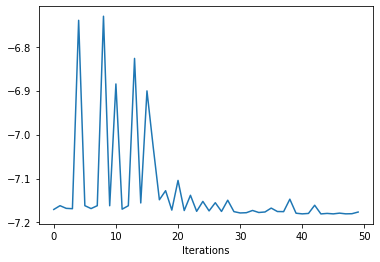

Schmidt Coefficients:


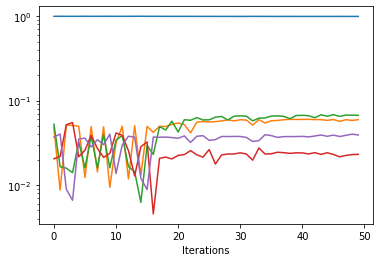

Parameters:


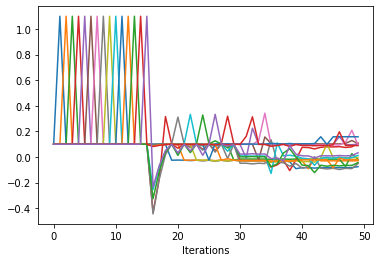

In [10]:
print("Energy:")
plt.plot([evaluation.eigenvalue for evaluation in results.history])
plt.xlabel("Iterations")
plt.show()

print("Schmidt Coefficients:")
plt.plot([abs(evaluation.eigenstate) for evaluation in results.history])
plt.xlabel("Iterations")
plt.yscale("log")
plt.show()

print("Parameters:")
plt.plot([evaluation.parameters for evaluation in results.history])
plt.xlabel("Iterations")
plt.show()

In [11]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright